In [1]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import scipy 
import sklearn.metrics

plt.style.use('seaborn-colorblind')
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rcParams.update({'font.size': 11})

/var/folders/54/80xxnq7j53g0ccwvp1kmvgzm0000gn/T/ipykernel_16043/4079999522.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


In [2]:
from platform import python_version
print(f'Python version: {python_version()}')
print(f'Scanpy version: {sc.__version__}')

Python version: 3.10.0
Scanpy version: 1.9.1


In [5]:
data_path = 'src/data/experiment_data/'

# Data Loading

In [10]:
# load raw protein dataset

filename = '20210919_DIANN_SingleCellOutput.pg_matrix_notnormalized.tsv'

cols = list(pd.read_csv(data_path + filename, nrows=1, sep='\t'))
prot = pd.read_csv(data_path + filename, usecols =[i for i in cols if 'TSCP_DIA_SingleCell' in i], sep='\t')
var_annotation = pd.read_csv(data_path + filename, index_col = 'Genes', usecols = ['Genes'], sep='\t')
prot = prot.fillna(0.)
prot[prot == 'Filtered'] = 0.

adata_prot_raw = anndata.AnnData(prot.transpose())
adata_prot_raw.var = var_annotation
adata_prot_raw.var_names = adata_prot_raw.var_names.map(str)
adata_prot_raw.var_names_make_unique()

/var/folders/54/80xxnq7j53g0ccwvp1kmvgzm0000gn/T/ipykernel_16043/432093977.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_prot_raw = anndata.AnnData(prot.transpose())
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [59]:
# load protein dataset with local regression normalization

filename = '20210919_DIANN_SingleCellOutput.pg_matrix_cellcyclepred.tsv'

cols = list(pd.read_csv(data_path + filename, nrows=1, sep='\t'))
prot = pd.read_csv(data_path + filename, usecols =[i for i in cols if 'TSCP_DIA_SingleCell' in i], sep='\t')
var_annotation = pd.read_csv(data_path + filename, index_col = 'Genes', usecols = ['Genes'], sep='\t')
prot[prot == 'Filtered'] = np.nan

adata_prot = anndata.AnnData(prot.transpose())
adata_prot.var = var_annotation
adata_prot.var_names = adata_prot.var_names.map(str)
adata_prot.var_names_make_unique()

protein_adata = adata_prot

/var/folders/54/80xxnq7j53g0ccwvp1kmvgzm0000gn/T/ipykernel_16043/878321781.py:10: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_prot = anndata.AnnData(prot.transpose())
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [60]:
protein_adata.X

array([[    nan,     nan,     nan, ...,     nan,     nan,     nan],
       [    nan, 1738.33, 1019.42, ...,     nan,     nan, 2504.45],
       [    nan,     nan,     nan, ...,     nan,     nan, 1590.36],
       ...,
       [    nan, 3261.2 ,     nan, ...,     nan,     nan,     nan],
       [    nan, 1847.35,     nan, ..., 4572.51,     nan, 1147.72],
       [    nan,     nan,     nan, ..., 2860.82,     nan,     nan]],
      dtype=float32)

In [12]:
# load data from "HeLa-CCL2 cell heterogeneity studied by single-cell DNA and RNA sequencing"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129447
# (SMART-Seq2 data from 9, 14 and 20 passages)

adata1 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713084_HeLa_1.txt').transpose()
adata2 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713085_HeLa_2.txt').transpose()
adata3 = anndata.read_text(data_path + 'GSE129447_RAW/GSM3713086_HeLa_3.txt').transpose()
adata3.var_names = adata1.var_names
adata2 = adata2[:, adata1.var_names] # without ERCC genes
smartseq_adata = anndata.concat([adata1, adata2, adata3])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
# load data from "The transcriptome dynamics of single cells during the cell cycle"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE142277

adata1_exon = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224315_out_gene_exon_tagged.dge_exonssf002_WT.txt').transpose()
adata1_intron = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224315_out_gene_exon_tagged.dge_intronssf002_WT.txt').transpose()
adata2_exon = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224316_out_gene_exon_tagged.dge_exonssf002_KO.txt').transpose()
adata2_intron = anndata.read_text(data_path + 'GSE142277_RAW/GSM4224316_out_gene_exon_tagged.dge_intronssf002_KO.txt').transpose()

intersection = list(set(adata1_exon.var_names).intersection(adata1_intron.var_names))
intersection_part = adata1_exon[:, intersection].copy()
intersection_part.X += adata1_intron[:, intersection].X
adata1_2 = anndata.concat([
        intersection_part, 
        adata1_exon[:, [gene for gene in adata1_exon.var_names if gene not in adata1_intron.var_names]],
        adata1_intron[:, [gene for gene in adata1_intron.var_names if gene not in adata1_exon.var_names]],
    ], axis=1)

intersection = list(set(adata2_exon.var_names).intersection(adata2_intron.var_names))
intersection_part = adata2_exon[:, intersection].copy()
intersection_part.X += adata2_intron[:, intersection].X
adata2_2 = anndata.concat([
        intersection_part, 
        adata2_exon[:, [gene for gene in adata2_exon.var_names if gene not in adata2_intron.var_names]],
        adata2_intron[:, [gene for gene in adata2_intron.var_names if gene not in adata2_exon.var_names]],
    ], axis=1)

# second dataset from "The transcriptome dynamics of single cells during the cell cycle"
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4226257

adata_exon = anndata.read_text(data_path + 'GSM4226257_RAW/GSM4226257_out_gene_exon_tagged.dge_exonsds_046.txt').transpose()
adata_intron = anndata.read_text(data_path + 'GSM4226257_RAW/GSM4226257_out_gene_exon_tagged.dge_intronsds_046.txt').transpose()

intersection = list(set(adata_exon.var_names).intersection(adata_intron.var_names))
intersection_part = adata_exon[:, intersection]
intersection_part.X += adata_intron[:, intersection].X
adata1_3 = anndata.concat([
        intersection_part, 
        adata_exon[:, [gene for gene in adata_exon.var_names if gene not in adata1_intron.var_names]],
        adata_intron[:, [gene for gene in adata_intron.var_names if gene not in adata1_exon.var_names]],
    ], axis=1)
adata1_3.var_names_make_unique()

tenx_adata = anndata.concat([adata1_2, adata2_2, adata1_3], join='outer', fill_value=0.)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## True Single-Cell Proteomics - Cell Cycle Analysis

### Fig. 4C - Total protein signal per cell grouped by cell cycle stage

In [14]:
adata_raw = adata_prot_raw.copy()
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=0.15 * adata_raw.shape[0])

adata_raw.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata_raw.obs_names
]

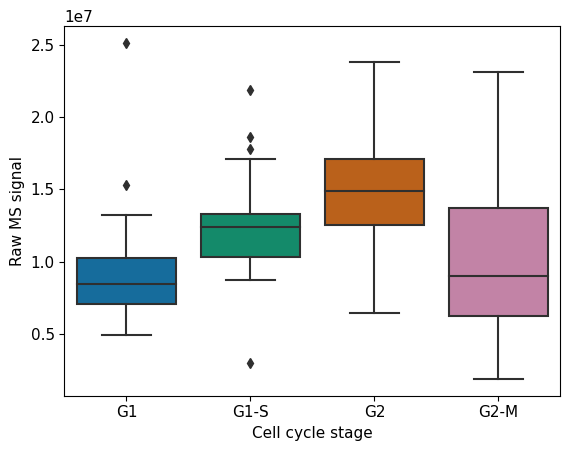

In [15]:
size = {cond: adata_raw[adata_raw.obs['cell cycle stage'] == cond].X.sum(axis=1)
       for cond in ['G1', 'G1-S', 'G2', 'G2-M']}
x = np.concatenate([[cond] * len(cells) for cond, cells in size.items()])
y = np.concatenate([cells for cells in size.values()])
sns.boxplot(x=x, y=y)
plt.xlabel("Cell cycle stage")
plt.ylabel("Raw MS signal")
plt.show()

In [16]:
adata_raw[adata_raw.obs['cell cycle stage'] == 'G1'].X

ArrayView([[   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
           [3202.92,    0.  ,    0.  , ...,    0.  ,    0.  , 1627.39],
           [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  , 1642.16],
           ...,
           [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
           [   0.  , 3246.02,    0.  , ...,    0.  ,    0.  ,    0.  ],
           [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ]],
          dtype=float32)

In [17]:
for cond, d in size.items():
    print(f'{cond}:\t n = {len(d)},\t median = {np.median(d)}')

G1:	 n = 84,	 median = 8477524.0
G1-S:	 n = 41,	 median = 12429287.0
G2:	 n = 52,	 median = 14910479.0
G2-M:	 n = 45,	 median = 9016382.0


### Fig. 4D - Principal Component Analysis

In [18]:
def impute_downshifted_normal_global(
        adata,
        scale=0.3,
        shift=1.8,
):
    np.random.seed(42)
    mean = np.nanmean(adata.X)
    std = np.nanstd(adata.X)
    draws = np.random.normal(loc=mean - shift * std, scale=scale * std, size=np.sum(np.isnan(adata.X)))
    adata.X[np.isnan(adata.X)] = draws

In [47]:
adata = protein_adata.copy()
adata

AnnData object with n_obs × n_vars = 434 × 2480

In [54]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
adata

AnnData object with n_obs × n_vars = 424 × 1867
    obs: 'n_genes'
    var: 'n_cells'

In [57]:
adata.X

array([[    nan,     nan,     nan, ..., 1382.11,     nan,     nan],
       [1738.33, 2594.51,     nan, ...,     nan,     nan, 2504.45],
       [    nan,     nan,     nan, ...,     nan,     nan, 1590.36],
       ...,
       [3261.2 ,     nan,     nan, ...,     nan,     nan,     nan],
       [1847.35,     nan, 2267.95, ...,     nan, 4572.51, 1147.72],
       [    nan,     nan,     nan, ...,     nan, 2860.82,     nan]],
      dtype=float32)

In [49]:
sc.pp.log1p(adata)
impute_downshifted_normal_global(adata)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

In [53]:
adata.X.sum(1)

ArrayView([14466.482 , 15106.171 , 14578.148 , 15040.727 , 15061.881 ,
           15107.404 , 14582.63  , 14994.996 , 15124.343 , 14587.2   ,
           15051.675 , 15071.875 , 15053.886 , 14374.764 , 14988.335 ,
           14926.624 , 14817.651 , 14876.168 , 14902.864 , 14630.723 ,
           14894.547 , 14496.947 , 14243.092 , 14790.869 , 14070.551 ,
           14026.173 , 14749.625 , 14485.767 , 14734.941 , 14809.969 ,
           14762.832 , 14746.115 , 14804.57  , 14810.863 , 14829.965 ,
           14152.951 , 14666.051 , 14842.283 , 14640.154 , 14697.849 ,
           14693.579 , 14795.758 , 14176.712 , 14478.929 , 14736.273 ,
           15005.186 , 15073.18  , 14806.06  , 14983.678 , 14975.885 ,
           14980.194 , 15007.079 , 14880.145 , 15004.941 , 14843.592 ,
           14979.444 , 14987.158 , 14999.58  , 14978.223 , 15033.162 ,
           15002.064 , 14950.244 , 14948.746 , 15035.744 , 15012.402 ,
           14967.496 , 14326.857 , 14975.368 , 14918.879 , 14972.592 ,
      

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


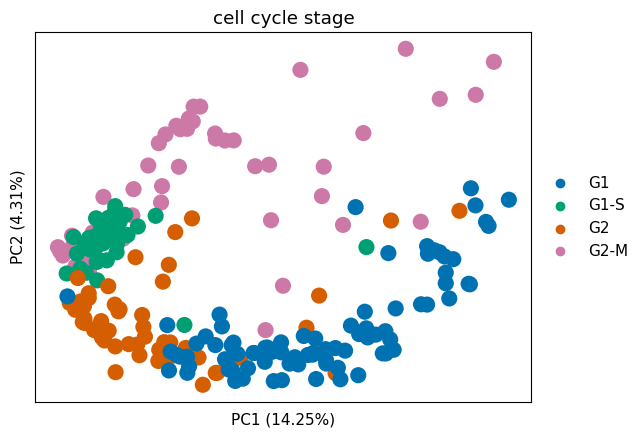

In [35]:
sc.pp.pca(adata)
sc.pl.pca(adata, color='cell cycle stage', annotate_var_explained=True)
plt.show()

In [42]:
adata.uns.data

OrderedDict([('log1p', {'base': None}),
             ('pca',
              {'params': {'zero_center': True, 'use_highly_variable': False},
               'variance': array([68.7623   , 20.815737 , 13.914147 , 12.204659 , 10.593524 ,
                       8.969628 ,  7.7953663,  7.3737   ,  6.524484 ,  5.8959374,
                       5.248616 ,  4.8360653,  4.7109213,  4.552986 ,  4.128794 ,
                       4.0572605,  3.9169936,  3.8381581,  3.7002964,  3.461445 ,
                       3.4187026,  3.4085386,  3.3222768,  3.2175357,  3.153857 ,
                       3.073984 ,  3.0512424,  3.0192485,  2.9493575,  2.9070961,
                       2.8799644,  2.851836 ,  2.826373 ,  2.7890627,  2.7592158,
                       2.7374637,  2.6927524,  2.6711018,  2.622943 ,  2.586965 ,
                       2.5589786,  2.5229473,  2.5132582,  2.5066192,  2.4859521,
                       2.4269085,  2.4020948,  2.385962 ,  2.3726008,  2.3412302],
                     dtype=f

In [21]:
adata

AnnData object with n_obs × n_vars = 222 × 1867
    obs: 'n_genes', 'cell cycle stage'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'cell cycle stage_colors'
    obsm: 'X_pca'
    varm: 'PCs'

### Fig. 4E - Cell cycle stage prediction 

In [76]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.7 * adata.shape[0])
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

In [77]:
cc_markers = pd.read_excel("src/data/experiment_data/CellCycleMarker.xlsx", "Tami_Geiger")

g1_list = cc_markers['G1'][1:-1]
g1_list = [g for g in g1_list if g in adata.var_names]
print(f'G1:\t {", ".join(g1_list)}')

s_list = cc_markers['S'][1:-1]
s_list = [g for g in s_list if g in adata.var_names]
print(f'S:\t {", ".join(s_list)}')

g2m_list = cc_markers['G2M'][1:-1]
g2m_list = [g for g in g2m_list if g in adata.var_names]
print(f'G2M:\t {", ".join(g2m_list)}')

G1:	 MARCKS, KRT1, HIST1H1E, KRT18, HNRNPA1, CHCHD3, CD44, NASP, TARDBP, PODXL, SUMO2, STMN1, TRIM28, SPTAN1
S:	 NOLC1, ATP2A2, CANX, TMX1, CKB, SLC25A3, SLC16A1, MT-CO2, SRPRB, CYB5R3, LETM1, ANP32B
G2M:	 TOP2A, HMGB1, EIF5B, TMSB10, EIF3D, ANP32A, RCC2, FASN, LUC7L2, AARS, KPNA2, CKAP5


In [78]:
sc.tl.score_genes(adata, g1_list, score_name='g1')
sc.tl.score_genes(adata, s_list, score_name='s')
sc.tl.score_genes(adata, g2m_list, score_name='g2m')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future 

In [80]:
adata.obs

,n_genes,cell cycle stage,g1,s,g2m
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873.d,1019,G2-M,0.030240,-0.462195,2.193410
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874.d,1835,G2-M,0.244431,0.083354,0.302430
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875.d,1095,G2-M,-1.684805,-2.017917,1.767509
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876.d,1664,G2-M,0.122282,-0.631195,-0.501734
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877.d,1992,G2-M,0.028765,0.058703,0.212347
...,...,...,...,...,...
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_154_S5-G10_1_4962.d,758,G1,0.982010,-0.272332,-0.733496
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_155_S5-G11_1_4963.d,740,G1,1.044770,-0.771712,0.909683
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_158_S5-H2_1_4966.d,687,G1,0.908701,-1.959550,0.621216
D:\TSCP_DIA_SingleCell_CellCycle\SCP_diaPASEF_RawDATA\20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_163_S5-H7_1_4971.d,836,G1,0.611939,0.894185,-0.807838


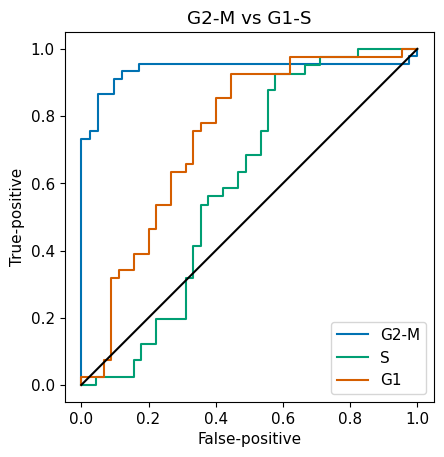

In [72]:
protein_data_nb_tb = adata[np.array(adata.obs['cell cycle stage'] == 'G2-M') 
                                  | np.array(adata.obs['cell cycle stage'] == 'G1-S')]

score = {
    'G2-M': protein_data_nb_tb.obs['g2m'].values,
    'S': protein_data_nb_tb.obs['s'].values,
    'G1': protein_data_nb_tb.obs['g1'].values
}

for phase in score.keys():
    true_label = np.array([phase in a for a in protein_data_nb_tb.obs['cell cycle stage'].values])
    scores = score[phase]
    fp, tp, _ = sklearn.metrics.roc_curve(true_label, scores)
    plt.plot(fp, tp, label=phase)
plt.plot([0, 1], [0, 1], c='black')
plt.gca().set_aspect('equal')
plt.xlabel('False-positive')
plt.ylabel('True-positive')
plt.legend()
plt.title('G2-M vs G1-S')
plt.show()

In [71]:
score

{'G2-M': array([ 2.1934099 ,  0.30243007,  1.7675093 , -0.50173432,  0.21234728,
         0.24809926,  1.13561113,  0.35660981,  0.22785865,  1.08738666,
         0.34236241,  0.16406939,  0.36487962,  2.38972943,  0.38770074,
         0.34413425,  0.53923399,  0.2940283 ,  0.43352679,  0.49848753,
         0.40883912,  1.81073885,  2.36232896,  0.40481702,  2.32954215,
         1.94395115,  0.43632794,  1.51330855,  0.46448429,  0.50879908,
         0.68928682,  0.71904986,  0.4383803 ,  0.40883608,  0.38700336,
         3.1590009 ,  0.65748624,  0.42049802,  0.84235216,  0.57503496,
         0.46430041,  0.27751447,  0.4278316 , -0.10476111,  0.42117853,
         0.11161995,  0.1642056 ,  0.06624599,  0.07934267,  0.10817806,
         0.01447123,  0.0498152 ,  0.13934952,  0.04885137,  0.26798882,
         0.07061226,  0.07031797,  0.05808154,  0.08778241,  0.11090296,
         0.10561518,  0.12747946,  0.16220586, -0.01186749,  0.1150764 ,
        -0.01332862,  0.35041414,  0.041077

In [51]:
for phase in score.keys():
    true_label = np.array([phase in a for a in protein_data_nb_tb.obs['cell cycle stage'].values])
    scores = score[phase]
    print(f'AUC using the {phase} score: {sklearn.metrics.roc_auc_score(true_label, scores):.2f}')

AUC using the G2-M score: 0.94
AUC using the S score: 0.60
AUC using the G1 score: 0.74


## True Single-Cell Proteomics - Comparison with Transcriptomics Data

### Fig. 5A - Gene expression completeness within cells

In [52]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMARTseq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [53]:
for datasetname, adata in full_data.items():
    print(f'{datasetname}\t {adata.shape},\t mean completeness per cell: {np.median((adata.X > 0).mean(axis=1)):.2f}')

Proteins	 (424, 2480),	 mean completeness per cell: 0.49
SMARTseq2	 (720, 24990),	 mean completeness per cell: 0.28
Drop-Seq	 (5022, 41161),	 mean completeness per cell: 0.07


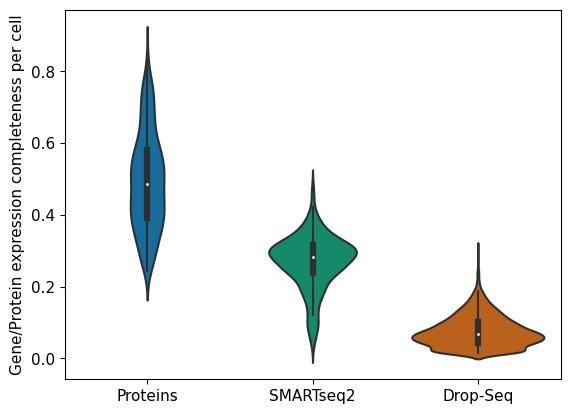

In [54]:
perc_expr = []
dataset_name = []
for datasetname, adata in full_data.items():
    perc_expr += list((adata.X > 0).mean(axis=1))
    dataset_name += [datasetname] * adata.X.shape[0]
sns.violinplot(y=perc_expr, x=dataset_name)
plt.ylabel('Gene/Protein expression completeness per cell')
plt.show()

### Fig. 5B - Principal Component Analysis

In [55]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
    
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)
    
intersection_data = {
    datasetname: adata[:, list(shared_genes)]
    for datasetname, adata in full_data.items()
}
    
for adata in intersection_data.values():
    adata.X = np.nan_to_num(adata.X)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.log1p(adata.X)
    
for datasetname, adata in intersection_data.items():
    adata.obs['dataset'] = datasetname
joined = anndata.concat([adata for adata in intersection_data.values()])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Library/Frameworks/Python.framework/Versions/3.10/l

In [56]:
intersection_data

{'Proteins': AnnData object with n_obs × n_vars = 424 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells',
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells',
 'Drop-Seq': AnnData object with n_obs × n_vars = 5022 × 1672
     obs: 'n_genes', 'dataset'
     var: 'n_cells'}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


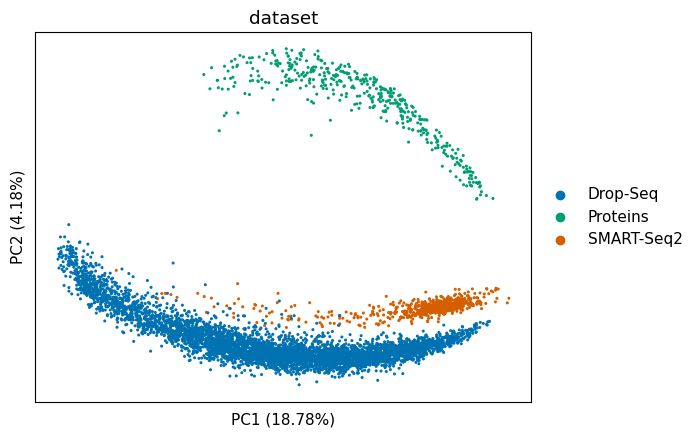

In [57]:
sc.pp.pca(joined)
ax = sc.pl.pca(joined, color='dataset', show=False, annotate_var_explained=True)
ax.invert_xaxis()
plt.show()

### Fig. 5C - Pearson Correlation Analysis

In [58]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))
    sc.pp.log1p(adata.X)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [59]:
for adata in full_data.values():
    np.random.shuffle(adata.X)

joined = anndata.concat(full_data.values()) # performs inner join
dataset_names = np.concatenate([[name] * adata.shape[0] for name, adata in full_data.items()])
print('number of shared genes:', joined.shape[1])

c = np.array(pd.DataFrame(joined.X.T).corr())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


number of shared genes: 1672


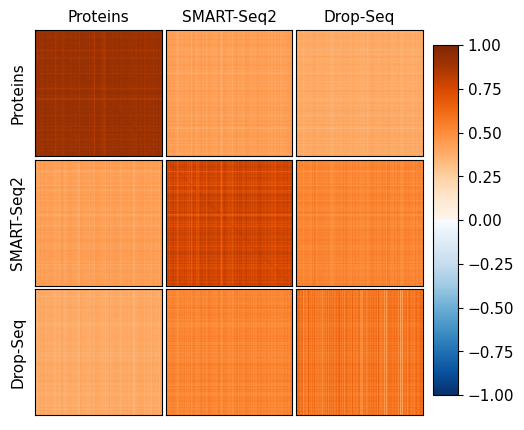

In [60]:
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

fig, ax = plt.subplots(3, 3, figsize=(5,5), gridspec_kw=dict(wspace=.03, hspace=.03))
for i, dataset_1 in enumerate(full_data.keys()):
    for j, dataset_2 in enumerate(full_data.keys()):
        subdata = c[dataset_names == dataset_1][:, dataset_names == dataset_2]
        color_obj = ax[i, j].imshow(subdata, vmin=-1, vmax=1, aspect='auto', cmap=newcmp)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        if i == 0:
            ax[i, j].set_title(dataset_2, fontsize=11)
        if j == 0:
            ax[i, j].set_ylabel(dataset_1, fontsize=11)

cbar_ax = fig.add_axes([.92, 0.15, 0.05, .7])
plt.colorbar(color_obj, cax=cbar_ax)
plt.show()

### Fig. 5D - Variance analysis

In [61]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

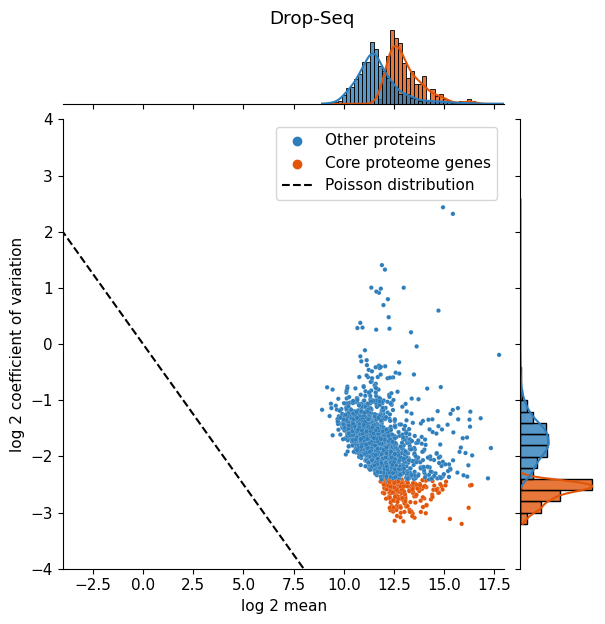

In [62]:
dir_core_proteome = 'CoreProteome.txt'
core_proteins = list(pd.read_csv(dir_core_proteome, sep='\t')['Genes'])

color = {
    'Core proteome genes': newcmp(.85),
    'Other proteins': newcmp(0.15)
}
adata.var['core/noncore'] = [
    'Core proteome genes' if prot in core_proteins 
    else 'Other proteins' 
    for prot in adata.var_names
]
mean = np.nanmean(adata.X, axis=0)
coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data

g = sns.JointGrid(
    x=np.log2(mean),
    y=np.log2(coeff_of_var),
    hue=adata.var['core/noncore'],
    palette=color,
)
g.plot_joint(
    sns.scatterplot, 
    s=10, 
    alpha=1,
    linewidth=.1
)
g.plot_marginals(
    sns.histplot, 
    kde=True, 
    stat='density', 
    common_norm=False,
    binwidth=.2,
    alpha=.8
)
g.ax_joint.set_xlabel('log 2 mean')
g.ax_joint.set_ylabel('log 2 coefficient of variation')
g.ax_joint.set_xlim(-4, 18)
g.ax_joint.set_ylim(-4, 4)
g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
g.ax_joint.legend(title=[])
plt.suptitle(datasetname, y=1)
plt.show()

### Fig. 5E - Variance comparison

In [63]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


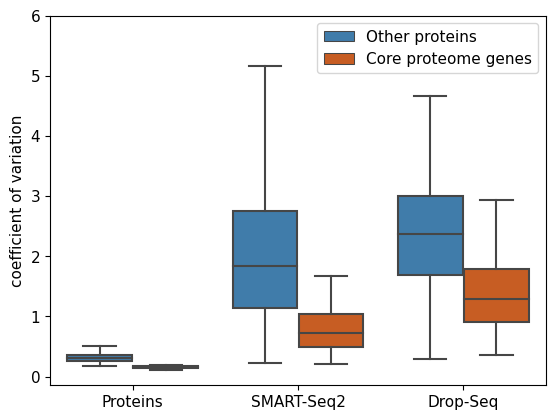

In [64]:
cov = []
hue = []
dataset_name = []

for datasetname, adata in full_data.items():
    adata.var['core/noncore'] = ['Core proteome genes' if prot in core_proteins else 'Other proteins' for prot in adata.var_names]
    mean = np.nanmean(adata.X, axis=0)
    coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data
    cov += list(coeff_of_var)
    hue += list(adata.var['core/noncore'])
    dataset_name += [datasetname] * adata.shape[1]

sns.boxplot(
    x = dataset_name, 
    y=cov, 
    hue=hue,
    palette=color,
    showfliers=False,
)
plt.ylabel('coefficient of variation')
plt.ylim(top=6)
plt.show()

## Supplementary Analyses

### Effect of Local Regression Normalisation

In [65]:
adata_normalised = protein_adata.copy()
sc.pp.filter_cells(adata_normalised, min_genes=600)
sc.pp.filter_genes(adata_normalised, min_cells=0.15 * adata_normalised.shape[0])
sc.pp.log1p(adata_normalised)
adata_normalised.X = np.nan_to_num(adata_normalised.X)

adata_raw = adata_prot_raw.copy()
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=0.15 * adata_raw.shape[0])
sc.pp.log1p(adata_raw)
adata_raw.X = np.nan_to_num(adata_raw.X)

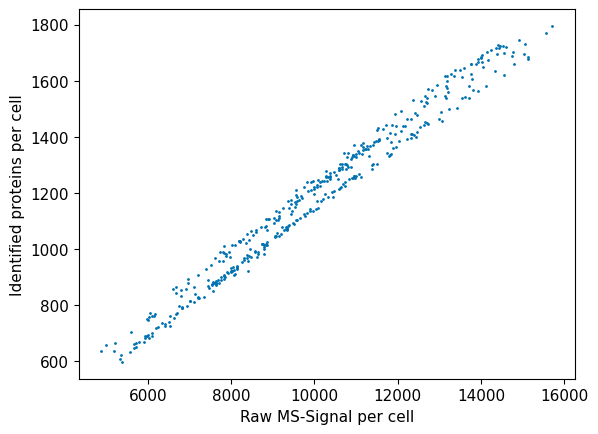

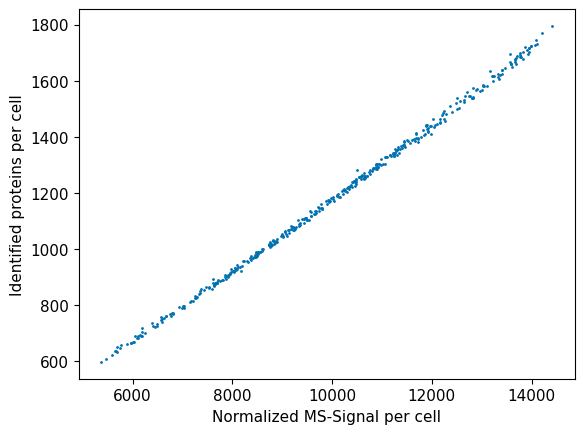

In [66]:
x = adata_raw.X.sum(axis=1)
y = (adata_raw.X > 0).sum(axis=1)
plt.scatter(x, y, s=1)
plt.xlabel('Raw MS-Signal per cell')
plt.ylabel('Identified proteins per cell')
plt.show()

x = adata_normalised.X.sum(axis=1)
y = (adata_normalised.X > 0).sum(axis=1)
plt.scatter(x, y, s=1)
plt.xlabel('Normalized MS-Signal per cell')
plt.ylabel('Identified proteins per cell')
plt.show()

### PCA including untreated cells

In [67]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
sc.pp.log1p(adata)
impute_downshifted_normal_global(adata)

adata.obs['condition'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'UB_Passage01' if 'UB' in name and '20201010' in name
    else 'UB_Passage02_Plate01' if 'UB' in name and int(name.split('_')[16].split('.')[0]) < 5050
    else 'UB_Passage02_Plate02'
    for name in adata.obs_names
]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


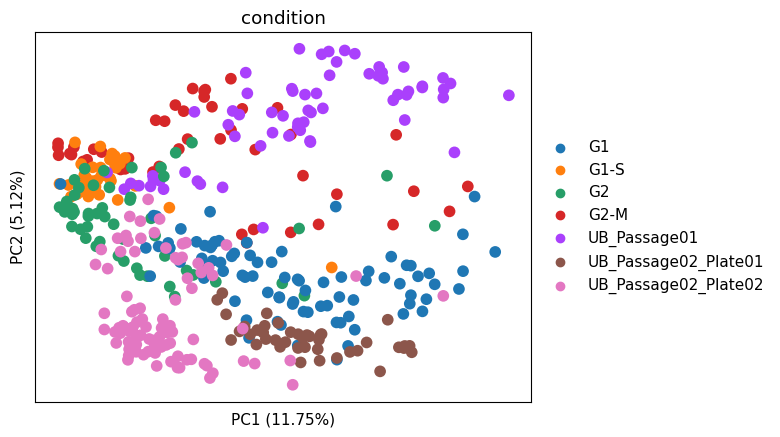

In [68]:
sc.pp.pca(adata)
sc.pl.pca(adata, color='condition', annotate_var_explained=True)
plt.show()

### Cell cycle stage prediction

In [69]:
adata = protein_adata.copy()
sc.pp.filter_cells(adata, min_genes=600)
sc.pp.filter_genes(adata, min_cells=0.7 * adata.shape[0])
sc.pp.log1p(adata)
adata.X = np.nan_to_num(adata.X)

adata.obs['cell cycle stage'] = [
    'G1' if '_G1_' in name
    else 'G1-S' if '_TB_' in name
    else 'G2' if '_G2_' in name
    else 'G2-M' if '_NB_' in name
    else 'other'
    for name in adata.obs_names
]
adata = adata[adata.obs['cell cycle stage'] != 'other']

In [70]:
cc_markers = pd.read_excel("CellCycleMarker.xlsx", "Tami_Geiger")

g1_list = cc_markers['G1'][1:-1]
g1_list = [g for g in g1_list if g in adata.var_names]
print(f'G1:\t {", ".join(g1_list)}')

s_list = cc_markers['S'][1:-1]
s_list = [g for g in s_list if g in adata.var_names]
print(f'S:\t {", ".join(s_list)}')

g2m_list = cc_markers['G2M'][1:-1]
g2m_list = [g for g in g2m_list if g in adata.var_names]
print(f'G2M:\t {", ".join(g2m_list)}')

G1:	 MARCKS, KRT1, HIST1H1E, KRT18, HNRNPA1, CHCHD3, CD44, NASP, TARDBP, PODXL, SUMO2, STMN1, TRIM28, SPTAN1
S:	 NOLC1, ATP2A2, CANX, TMX1, CKB, SLC25A3, SLC16A1, MT-CO2, SRPRB, CYB5R3, LETM1, ANP32B
G2M:	 TOP2A, HMGB1, EIF5B, TMSB10, EIF3D, ANP32A, RCC2, FASN, LUC7L2, AARS, KPNA2, CKAP5


In [71]:
sc.tl.score_genes(adata, g1_list, score_name='g1')
sc.tl.score_genes(adata, s_list, score_name='s')
sc.tl.score_genes(adata, g2m_list, score_name='g2m')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future 

AUC using the G2-M score: 0.46
AUC using the S score: 0.35
AUC using the G1 score: 0.67


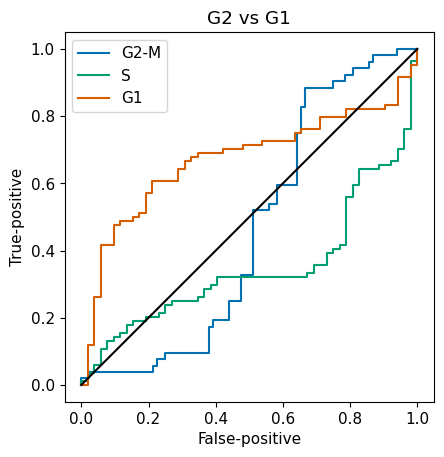

AUC using the G2-M score: 0.66
AUC using the S score: 0.52
AUC using the G1 score: 0.84


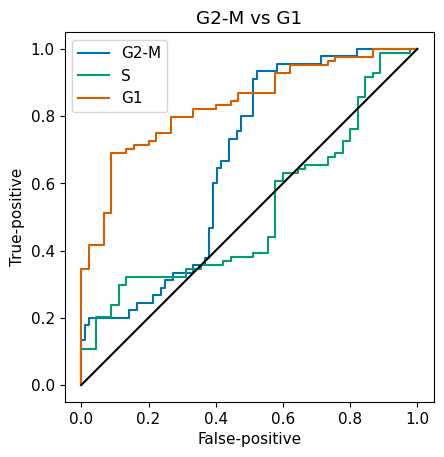

In [72]:
for pair in [('G2', 'G1'), ('G2-M', 'G1')]:
    data_comparison = adata[np.array(adata.obs['cell cycle stage'] == pair[0]) 
                                      | np.array(adata.obs['cell cycle stage'] == pair[1])]

    score = {}
    score['G2-M'] = data_comparison.obs['g2m'].values
    score['S'] = data_comparison.obs['s'].values
    score['G1'] = data_comparison.obs['g1'].values
    
    for phase in score.keys():
        true_label = np.array([phase in a or (phase == 'S' and a == 'G1') or a in phase for a in data_comparison.obs['cell cycle stage'].values])
        scores = score[phase]
        print(f'AUC using the {phase} score: {sklearn.metrics.roc_auc_score(true_label, scores):.2f}')
        fp, tp, _ = sklearn.metrics.roc_curve(true_label, scores)
        plt.plot(fp, tp, label=phase)
    plt.plot([0, 1], [0, 1], c='black')
    plt.gca().set_aspect('equal')
    plt.xlabel('False-positive')
    plt.ylabel('True-positive')
    plt.legend()
    plt.title(f'{pair[0]} vs {pair[1]}')
    plt.show()

### Data completeness

In [73]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Proteins (424, 2447)
SMART-Seq2 (720, 2447)
Drop-Seq (5022, 2447)


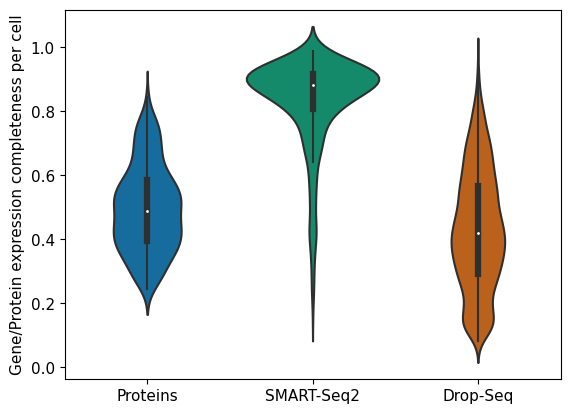

In [74]:
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)
    
intersection_data = {
    datasetname: adata[:, list(shared_genes)]
    for datasetname, adata in full_data.items()
}

perc_expr = []
dataset_name = []
for datasetname, adata in intersection_data.items():
    print(f'{datasetname} {adata.shape}')
    perc_expr += list((adata.X > 0).mean(axis=1))
    dataset_name += [datasetname] * adata.X.shape[0]
sns.violinplot(y=perc_expr, x=dataset_name)
plt.ylabel('Gene/Protein expression completeness per cell')
plt.show()

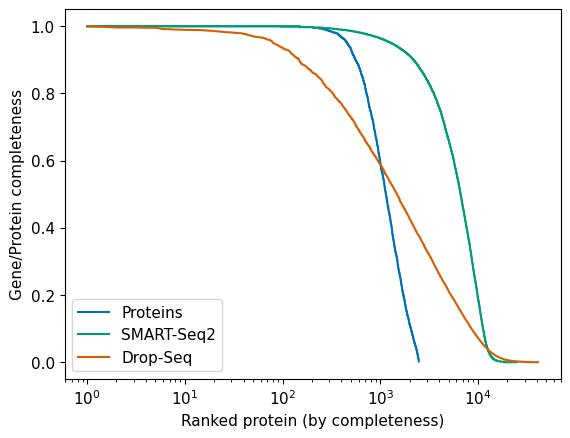

In [75]:
for name, adata in full_data.items():
    completeness = (adata.X > 0).sum(axis=0) / adata.X.shape[0]
    sorted_completeness = np.sort(completeness)[::-1]
    plt.plot(np.arange(len(sorted_completeness)) + 1, sorted_completeness, label=name)

plt.legend()
plt.ylabel('Gene/Protein completeness')
plt.xlabel('Ranked protein (by completeness)')
plt.xscale("log")
plt.show()

/var/folders/54/80xxnq7j53g0ccwvp1kmvgzm0000gn/T/ipykernel_65339/1305646746.py:4: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x), y, s=1, label=datasetname)
/var/folders/54/80xxnq7j53g0ccwvp1kmvgzm0000gn/T/ipykernel_65339/1305646746.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(x2), 1-np.exp(-x2), c='black', label='expected poisson dropout')


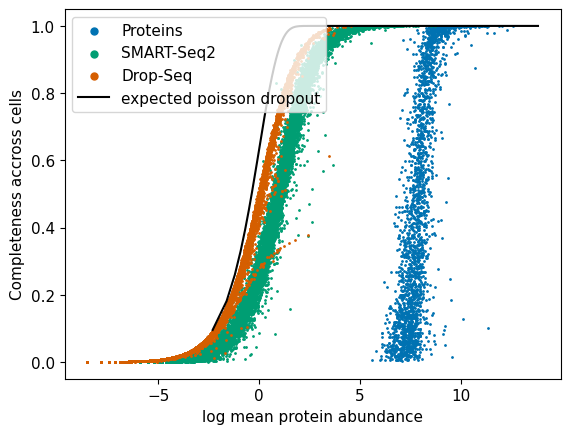

In [76]:
for datasetname, adata in full_data.items():
    x = np.nanmean(adata.X, axis=0)
    y = np.nanmean(adata.X > 0, axis=0)
    plt.scatter(np.log(x), y, s=1, label=datasetname)
    
# Pois(0) = exp(-mean) -> prob for k zeros in n cells = Binom(k|p, n), with expectation p*n -> divide by n
x2 = np.arange(0, 1000000, 0.1)
plt.plot(np.log(x2), 1-np.exp(-x2), c='black', label='expected poisson dropout')
plt.xlabel('log mean protein abundance')
plt.ylabel('Completeness accross cells')
plt.legend(markerscale=5., loc='upper left')
plt.show()

### Variance analyses

In [77]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    print(name, np.mean(np.nansum(adata.X, axis=1)))
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Proteins 9631877.0
SMART-Seq2 231281.56
Drop-Seq 7808.1196


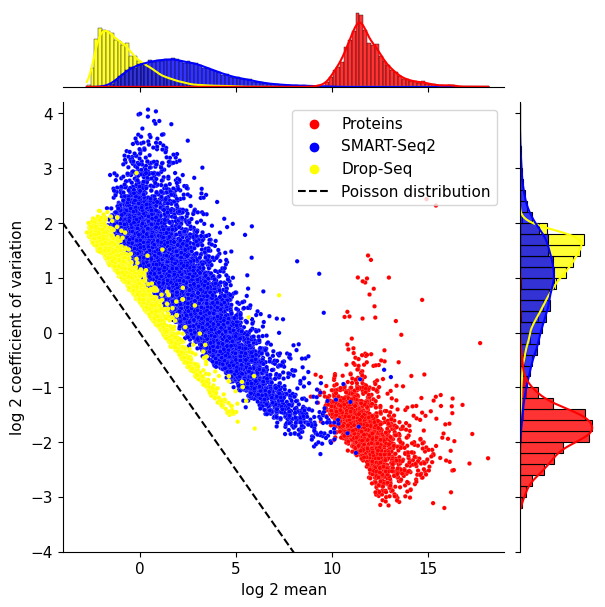

In [78]:
mean = []
coeff_of_var = []
name = []
for datasetname, adata in full_data.items():
    data = adata.X.copy()
    mean += list(np.nanmean(data, axis=0))
    coeff_of_var +=  list(scipy.stats.variation(data, nan_policy='omit').data)
    name += [datasetname] * len(np.nanmean(data, axis=0))
    
color = {
    'Proteins': 'red',
    'SMART-Seq2': 'blue',
    'Drop-Seq': 'yellow',
}

g = sns.JointGrid(
    x=np.log2(mean),
    y=np.log2(coeff_of_var),
    hue=name,
    palette=color,
)
g.plot_joint(
    sns.scatterplot, 
    s=10, 
    alpha=1,
    linewidth=.1
)
g.plot_marginals(
    sns.histplot, 
    kde=True, 
    stat='density', 
    common_norm=False,
    binwidth=.2,
    alpha=.8
)
g.ax_joint.set_xlabel('log 2 mean')
g.ax_joint.set_ylabel('log 2 coefficient of variation')
g.ax_joint.set_xlim(-4, 19)
g.ax_joint.set_ylim(-4, 4.2)
g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
g.ax_joint.legend(title=[])
plt.show()

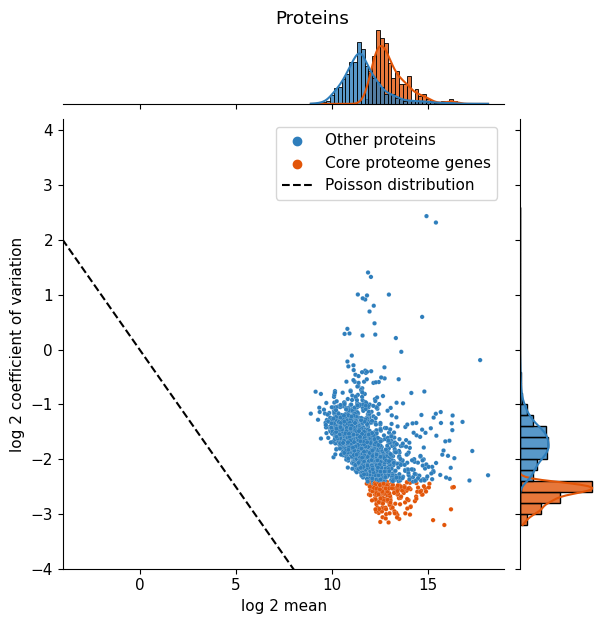

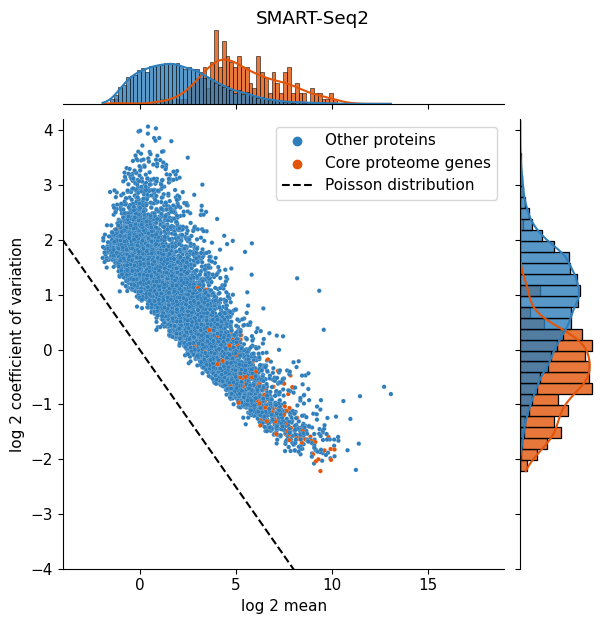

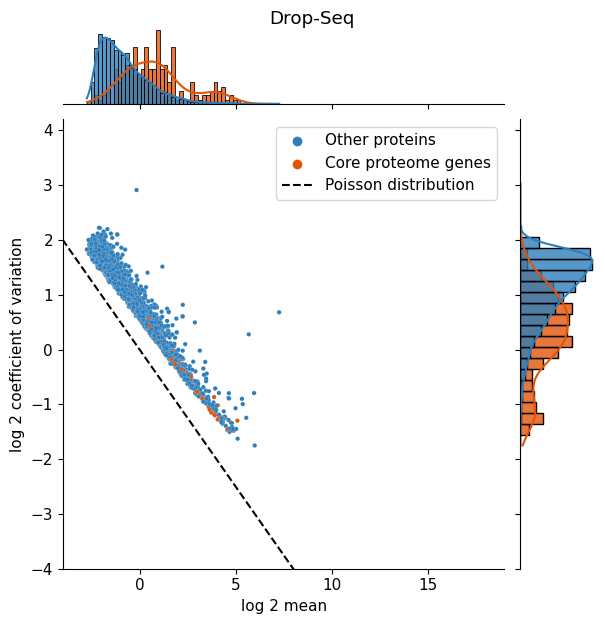

In [79]:
dir_core_proteome = 'CoreProteome.txt'
core_proteins = list(pd.read_csv(dir_core_proteome, sep='\t')['Genes'])

cov = []
hue = []
dataset_name = []
color = {
    'Core proteome genes': newcmp(.85),
    'Other proteins': newcmp(0.15)
}

for datasetname, adata in full_data.items():    
    adata.var['core/noncore'] = ['Core proteome genes' if prot in core_proteins else 'Other proteins' for prot in adata.var_names]
    mean = np.nanmean(adata.X, axis=0)
    coeff_of_var = scipy.stats.variation(adata.X, nan_policy='omit').data
    cov += list(coeff_of_var)
    hue += list(adata.var['core/noncore'])
    g = sns.JointGrid(
        x=np.log2(mean),
        y=np.log2(coeff_of_var),
        hue=adata.var['core/noncore'],
        palette=color,
    )
    g.plot_joint(
        sns.scatterplot, 
        s=10, 
        alpha=1,
        linewidth=.1
    )
    g.plot_marginals(
        sns.histplot, 
        kde=True, 
        stat='density', 
        common_norm=False,
        binwidth=.2,
        alpha=.8
    )
    g.ax_joint.set_xlabel('log 2 mean')
    g.ax_joint.set_ylabel('log 2 coefficient of variation')
    g.ax_joint.set_xlim(-4, 19)
    g.ax_joint.set_ylim(-4, 4.2)
    g.ax_joint.plot([-6, 10], [3, -5], '--',c='black', label='Poisson distribution')
    g.ax_joint.legend(title=[])
    plt.suptitle(datasetname, y=1)
    plt.show()

In [80]:
inter = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    inter = inter.intersection(adata.var_names)

intersection_data = {}
for datasetname, adata in full_data.items():
    intersection_data[datasetname] = adata[:, list(inter)]

cvs = {}
for datasetname, adata in intersection_data.items():
    cvs[datasetname] = scipy.stats.variation(adata.X, nan_policy='omit').data

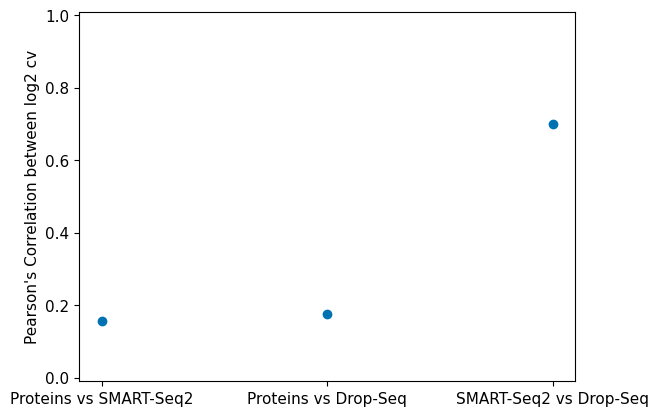

In [81]:
x = []
y = []
for pair in [('Proteins', 'SMART-Seq2'), ('Proteins', 'Drop-Seq'), ('SMART-Seq2', 'Drop-Seq')]:
    r = scipy.stats.pearsonr(np.log2(cvs[pair[0]]), np.log2(cvs[pair[1]]))[0]
    x.append(f'{pair[0]} vs {pair[1]}')
    y.append(r)

plt.scatter(
    x=x, 
    y=y,
)
plt.ylabel('Pearson\'s Correlation between log2 cv')
plt.ylim(-0.01, 1.01)
plt.show()

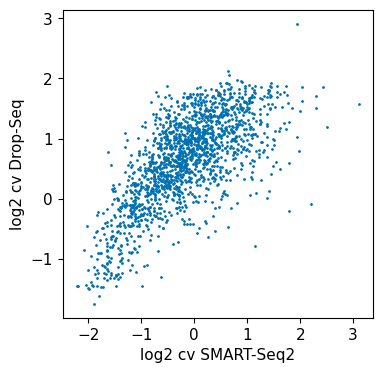

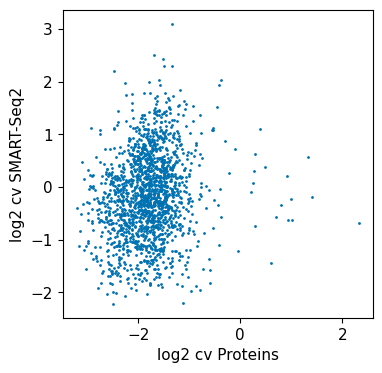

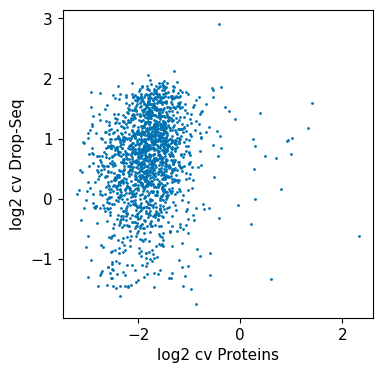

In [82]:
for pair in [('SMART-Seq2', 'Drop-Seq'), ('Proteins', 'SMART-Seq2'), ('Proteins', 'Drop-Seq')]:
    plt.figure(figsize=(4,4))
    plt.scatter(np.log2(cvs[pair[0]]), np.log2(cvs[pair[1]]), s=1)
    plt.xlabel(f'log2 cv {pair[0]}')
    plt.ylabel(f'log2 cv {pair[1]}')
    plt.show()

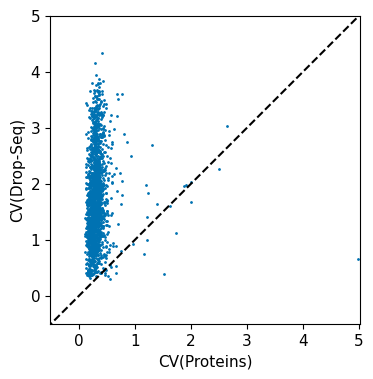

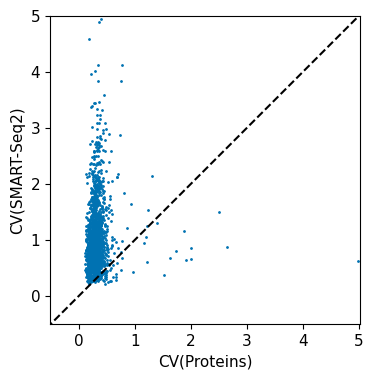

In [83]:
for pair in [('Proteins', 'Drop-Seq'), ('Proteins', 'SMART-Seq2')]:
    plt.figure(figsize=(4,4))
    plt.scatter(cvs[pair[0]], cvs[pair[1]], s=1)
    plt.xlabel(f'CV({pair[0]})')
    plt.ylabel(f'CV({pair[1]})')
    plt.plot([-1, 5], [-1, 5], '--', c='black')
    plt.axis('equal')
    plt.gca().set_ylim(-.5, 5)
    plt.gca().set_xlim(-.5, 5)
    plt.show()

### Correlation analyses

In [85]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

for name, adata in full_data.items():
    if name != 'Proteins':
        sc.pp.normalize_total(adata, target_sum=np.mean(np.nansum(adata.X, axis=1)))
    sc.pp.log1p(adata.X)
    
shared_genes = set(full_data['Proteins'].var_names)
for adata in full_data.values():
    shared_genes = shared_genes.intersection(adata.var_names)

intersection_data = {}
for datasetname, adata in full_data.items():
    intersection_data[datasetname] = adata[:, list(shared_genes)]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


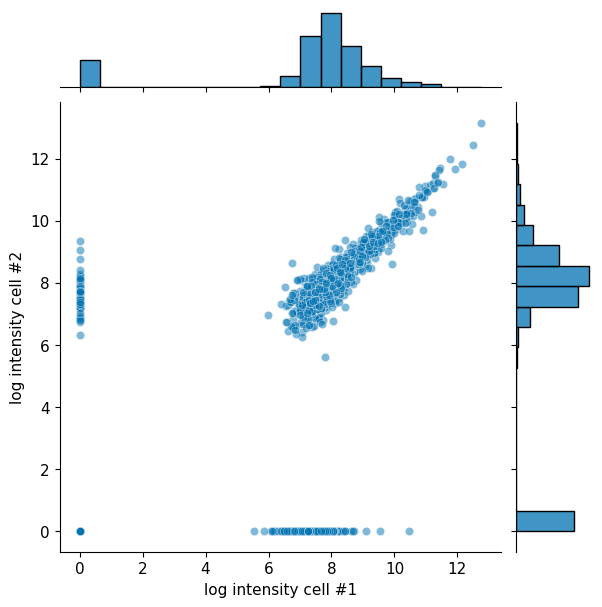

In [88]:
cell1 = np.nan_to_num(full_data['Proteins'].X[14, :].copy())
cell2 = np.nan_to_num(full_data['Proteins'].X[15, :].copy())

grid = sns.jointplot(x=cell1, y=cell2, alpha=0.5, marginal_kws={'bins': 20})
grid.set_axis_labels('log intensity cell #1', 'log intensity cell #2')
plt.show()

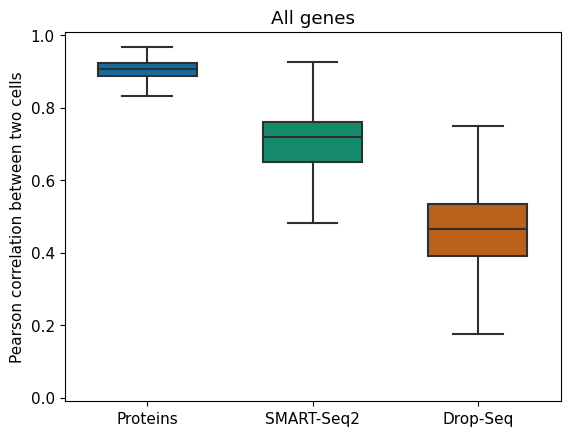

In [89]:
r_values = []
data_type = []

for datasetname, adata in full_data.items():
    r = np.array(pd.DataFrame(adata.X).T.corr())
    np.fill_diagonal(r, np.nan)
    r_vals = [val for val in r.flatten() if not np.isnan(val)]
    r_values += r_vals
    data_type += [datasetname] * len(r_vals)

r_vals = np.array(r_values)
for datasetname in full_data.keys():
    corrs = r_vals[np.array(data_type) == datasetname]

ax = sns.boxplot(
    x=data_type,
    y=r_values,
    width=0.6,
    showfliers=False,
)        
ax.set_ylabel("Pearson correlation between two cells")
plt.ylim(-0.01, 1.01)
plt.title('All genes')
plt.show()

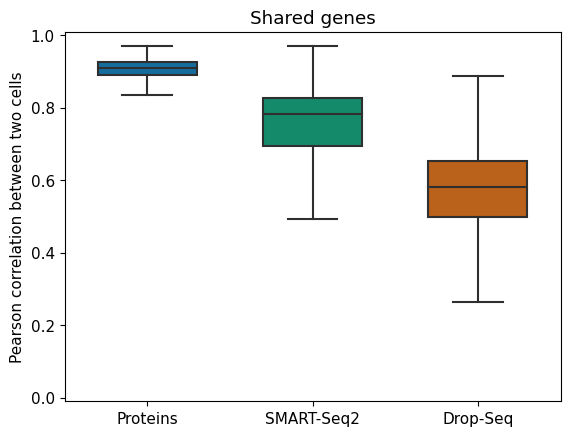

In [90]:
r_values = []
data_type = []

for datasetname, adata in intersection_data.items():
    r = np.array(pd.DataFrame(adata.X).T.corr())
    np.fill_diagonal(r, np.nan)
    r_vals = [val for val in r.flatten() if not np.isnan(val)]
    r_values += r_vals
    data_type += [datasetname] * len(r_vals)

r_vals = np.array(r_values)
for datasetname in full_data.keys():
    corrs = r_vals[np.array(data_type) == datasetname]

ax = sns.boxplot(
    x=data_type,
    y=r_values,
    width=0.6,
    showfliers=False,
)        
ax.set_ylabel("Pearson correlation between two cells")
plt.ylim(-0.01, 1.01)
plt.title('Shared genes')
plt.show()

### Abundance value distributions

In [91]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}

for adata in full_data.values():
    sc.pp.log1p(adata.X)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


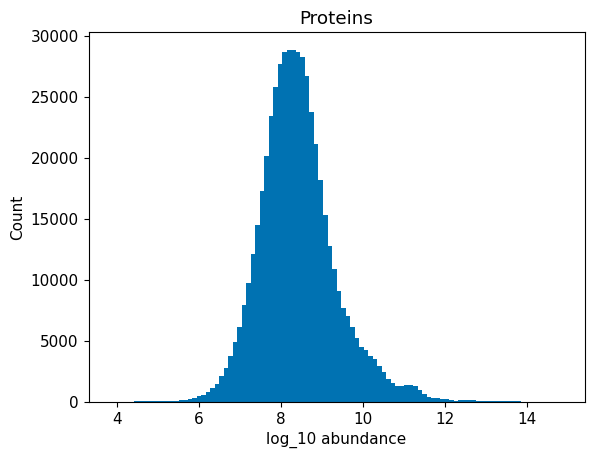

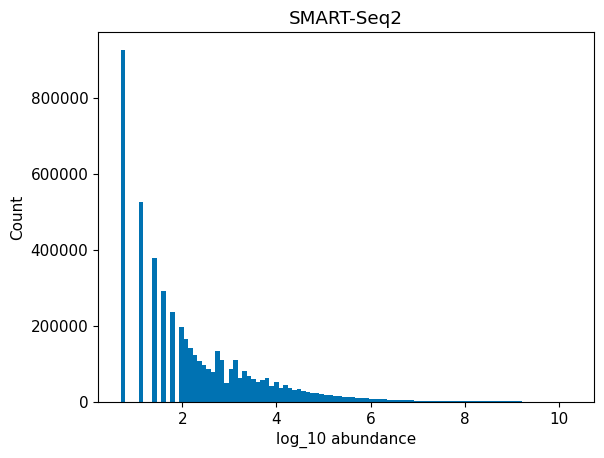

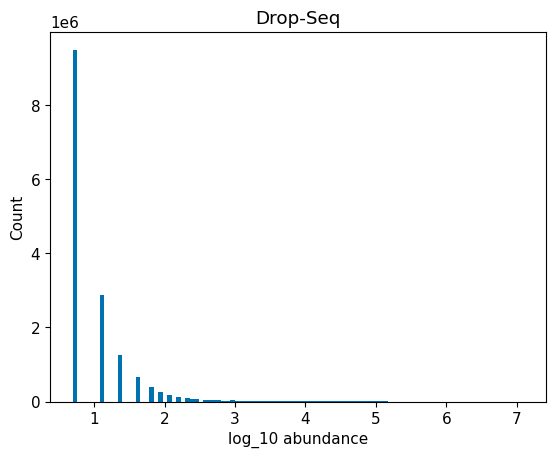

In [92]:
for name, adata in full_data.items():
    vals = adata.X.flatten()
    vals = vals[vals != 0]
    plt.hist(vals, bins=100)
    plt.title(name)
    plt.xlabel('log_10 abundance')
    plt.ylabel('Count')
    plt.show()

### Data before and after filtering

In [93]:
full_data = {
    'Proteins': protein_adata.copy(), 
    'SMART-Seq2': smartseq_adata.copy(),
    'Drop-Seq': tenx_adata.copy(),
}
print('Before filtering:')
full_data

Before filtering:


{'Proteins': AnnData object with n_obs × n_vars = 434 × 2480,
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 24990,
 'Drop-Seq': AnnData object with n_obs × n_vars = 5665 × 41161}

In [94]:
for adata in full_data.values():
    sc.pp.filter_cells(adata, min_genes=600)
    sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])
print('After filtering:')
full_data

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After filtering:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


{'Proteins': AnnData object with n_obs × n_vars = 424 × 1867
     obs: 'n_genes'
     var: 'n_cells',
 'SMART-Seq2': AnnData object with n_obs × n_vars = 720 × 10557
     obs: 'n_genes'
     var: 'n_cells',
 'Drop-Seq': AnnData object with n_obs × n_vars = 5022 × 6701
     obs: 'n_genes'
     var: 'n_cells'}